# Assignment 2

In this assignment you will create a coordinate-based multilayer perceptron in numpy from scratch. For each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

You will then compare the following input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Some notes to help you with that:

- You will implement the mappings in the helper functions `get_B_dict` and `input_mapping`. 
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix. 
- For this assignment, $d$ is 2 because the input coordinates in two dimensions. 
- You can experiment with $m$, like $m=256$.
- You should show results for $\sigma$ value of 1.

Source: https://bmild.github.io/fourfeat/ 
This assignment is inspired by and built off of the authors' demo. 

## Setup

### (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. Replace the path below with the path in your Google Drive to the uploaded assignment folder. Mounting to Google Drive will allow you access the other .py files in the assignment folder and save outputs to this folder

### Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np

# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

## Helper Functions

### Image Data and Feature Mappings (Fill in TODOs)

In [2]:
# Data loader - already done for you
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center  
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

In [280]:
# Create the mappings dictionary of matrix B -  you will implement this
# Assume Image(x,y) = v
# We are new calculating new value of v, which is a map of v 
# We map it to frequency: v ==> (cos(2\pi * B * v), sin(2\pi * B * v)
def get_B_dict(size): 
  mapping_size = size // 2 # you may tweak this hyperparameter
  B_dict = {}
  B_dict['none'] = None
  
  # add B matrix for basic, gauss_1.0
  # TODO implement this
  # * B_basic["basic"]: 
  B_dict['basic'] = np.eye(2)
  B_dict['gauss_1.0'] = np.random.normal(0, 1, (mapping_size, 2))
  B_dict["gauss_0.1"] = np.random.normal(0, 0.1, (mapping_size, 2))
  B_dict["gauss_10"] = np.random.normal(0, 10, (mapping_size, 2))
  B_dict["gauss_100"] = np.random.normal(0, 100, (mapping_size, 2))
  return B_dict

In [126]:
# Given tensor x of input coordinates, map it using B - you will implement
def input_mapping(x, B):
  if B is None:
    # "none" mapping - just returns the original input coordinates
    return x
  else:
    # "basic" mapping and "gauss_X" mappings project input features using B
    # x - (h * w, 2) B - (mapping_size, 2) ==> (h * w, mapping_size)
    # TODO implement this
    x_map = np.dot(2 * np.pi * x, B.T)
    return np.concatenate([np.cos(x_map), np.sin(x_map)], axis=-1)

### MSE Loss and PSNR Error (Fill in TODOs)

In [5]:
def mse(y, p):
  # TODO implement this
  # make sure it is consistent with your implementation in neural_net.py
  return np.mean((y - p)**2) * y.shape[1]

def psnr(y, p):
  # TODO implement this
  return 10 * np.log10(1 / mse(y, p))

In [290]:
size = 32
input_size = size * size
train_data, test_data = get_image(size)
print(test_data[1].size, test_data[0].reshape(-1, 2).shape)

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning rate: 1e-4


In [252]:
# TODO: Set the hyperparameters
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 2000
learning_rate = 1e-4
mapping_size = 32
output_size = 3
B_dict = get_B_dict(mapping_size)

print('B_dict items:')
for k,v in B_dict.items():
    print('\t',k,np.array(v).shape)

B_dict items:
	 none ()
	 basic (2, 2)
	 gauss_1.0 (16, 2)


In [8]:
# Apply the input feature mapping to the train and test data - already done for you
def get_input_features(B_dict, mapping):
  # mapping is the key to the B_dict, which has the value of B
  # B is then used with the function `input_mapping` to map x  
  y_train = train_data[1].reshape(-1, output_size)
  y_test = test_data[1].reshape(-1, output_size)
  X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
  X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
  return X_train, y_train, X_test, y_test

In [207]:
def lr_scheduler(lr, epoch, stepsize, gamma):
    if (epoch + 1) % stepsize == 0:
        return lr * gamma
    else:
        return lr

### Plotting and video helper functions (you don't need to change anything here)

In [253]:
def plot_training_curves(train_loss, test_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')
  plt.legend()

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_reconstruction(p, y):
  p_im = p.reshape(size,size,3)
  y_im = y.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  # print("Final Test MSE", mse(y, p))
  # print("Final Test psnr",psnr(y, p))

def plot_reconstruction_progress(predicted_images, y, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

# Save out video
def create_and_visualize_video(outputs, size=size, epochs=epochs, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

### Experiment Runner (Fill in TODOs)

In [212]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, stepsize, gamma, opt, **kwargs):

    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_size, output_size, num_layers, opt)
    if opt == 'SGD':
      net.SGD_optimizer(learning_rate)
    elif opt == 'Adam':
      net.Adam_optimizer(learning_rate, **kwargs)
    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))
    test_loss = np.zeros(epochs)
    print(epochs, stepsize, gamma, learning_rate, opt, kwargs)
    # For each epoch...
    for epoch in tqdm(range(epochs)):

      # Shuffle the dataset
      # TODO implement this
      indices = np.arange(X_train.shape[0])
      np.random.shuffle(indices)
      X_train_shuffle = X_train[indices]
      y_train_shuffle = y_train[indices]
      y_pred = net.forward(X_train_shuffle)
    # Run the backward pass of the model to compute the loss, record the loss, and update the weights
      # TODO implement this
      loss = net.backward(y_train_shuffle)
      
      learning_rate = lr_scheduler(learning_rate, epoch, stepsize, gamma)
      net.update(opt=opt)
      net.optimizer_step(learning_rate)    
      # Testing
      # No need to run the backward pass here, just run the forward pass to compute and record the psnr
      # validate_image = net.forward(X_train)
      y_pred = net.forward(X_train)
      train_psnr[epoch] = psnr(y_train, y_pred)
      predicted_images[epoch] = net.forward(X_test)
      # TODO implement this
      train_loss[epoch] = mse(y_train, y_pred)
      test_loss[epoch] = mse(y_test, predicted_images[epoch])
      test_psnr[epoch] = psnr(y_test, predicted_images[epoch])

    return net, train_psnr, test_psnr, train_loss, test_loss, predicted_images

# Low Resolution Reconstruction

#### Low Resolution Reconstruction - SGD - None Mapping

In [256]:
# TODO: Set the hyperparameters
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 2000
mapping_size = 32
learning_rate = 1e-1

2000 300 0.5 0.1 SGD {}


  0%|          | 0/2000 [00:00<?, ?it/s]

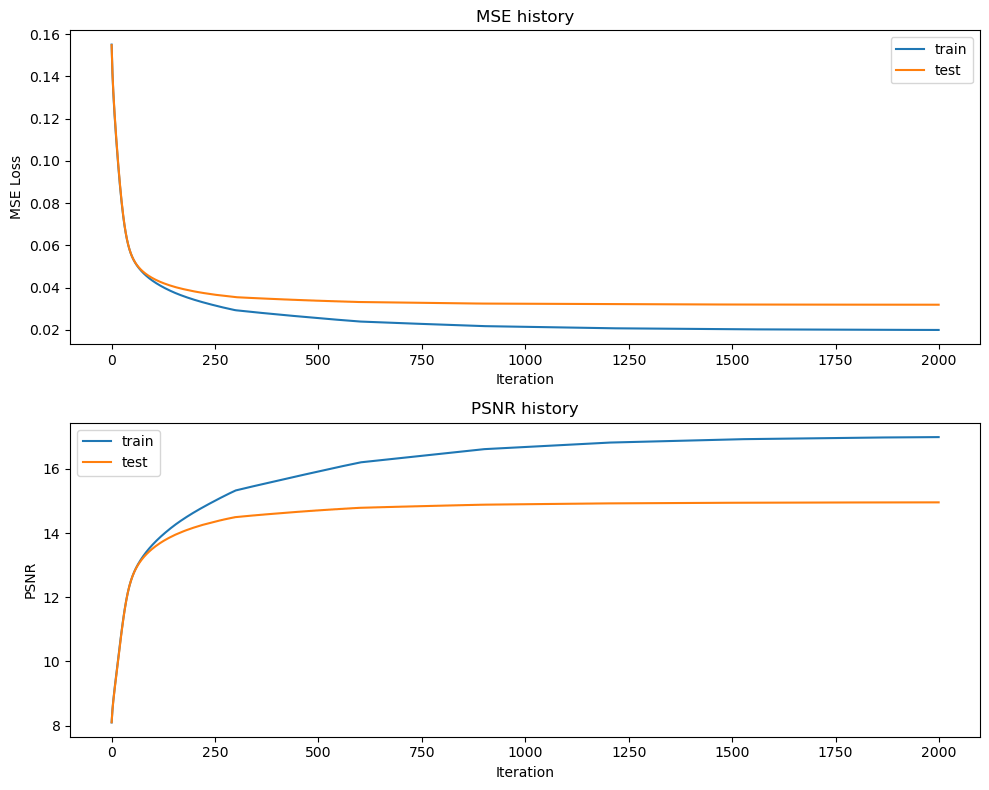

TypeError: 'float' object cannot be interpreted as an integer

In [257]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict(mapping_size)
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_1.0')
# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
net, train_psnr, test_psnr, train_loss, test_loss, predicted_images = \
    NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, stepsize=300, gamma=0.5, opt="SGD")
# plot results of experiment
plot_training_curves(train_loss, test_loss, train_psnr, test_psnr)
size /= 2
plot_reconstruction(net.forward(X_train), y_train)
size *= 2
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

In [239]:
# TODO: Set the hyperparameters for Adam
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 2000
learning_rate = 3 * 1e-5

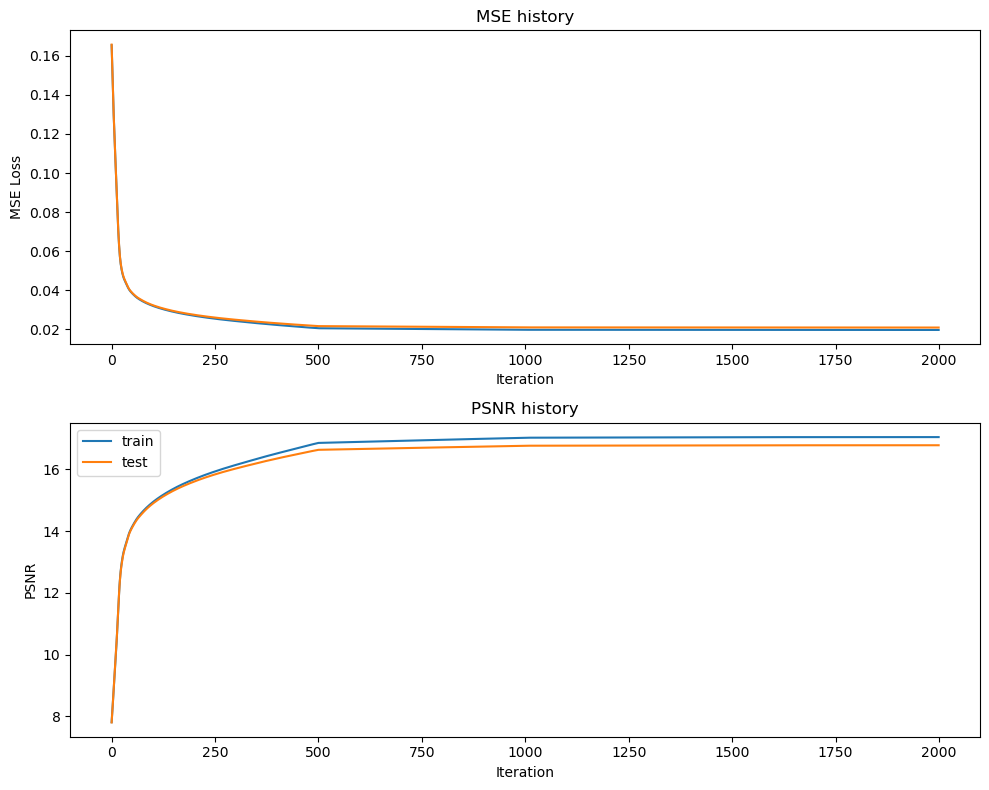

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\3713347882.py:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


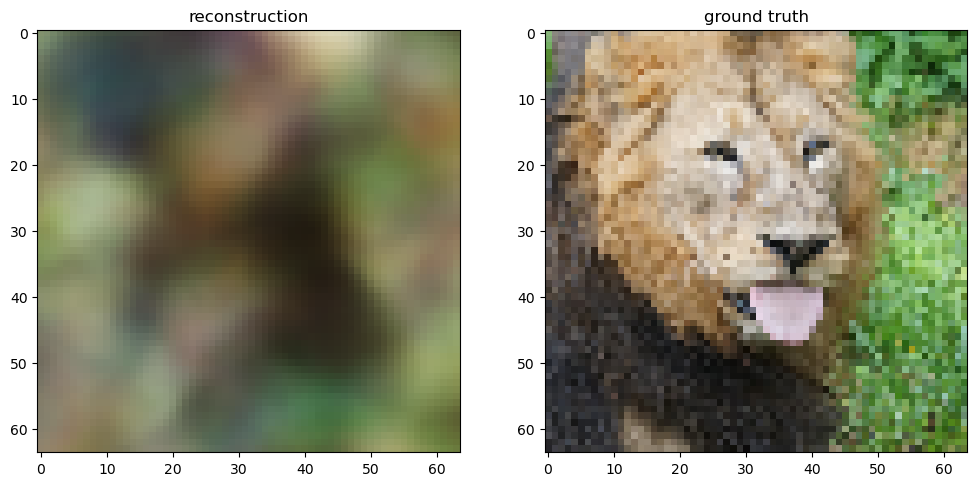

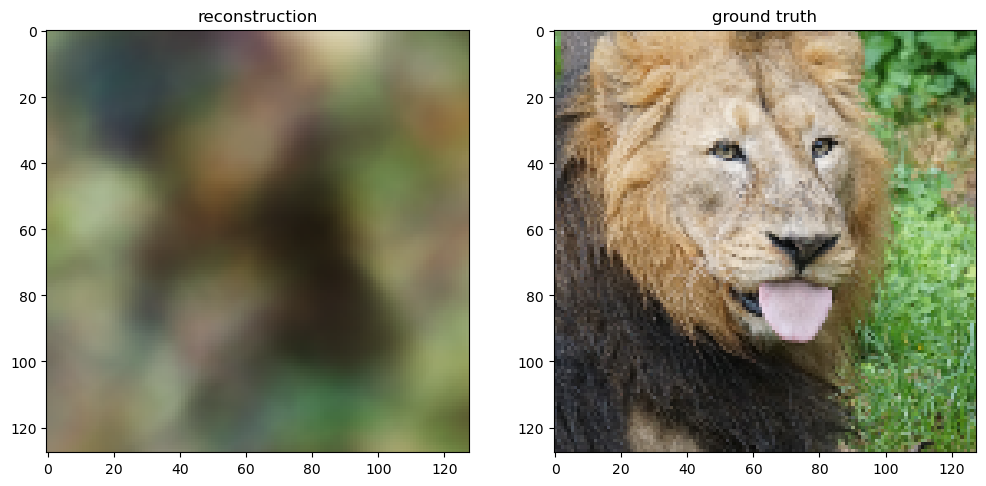

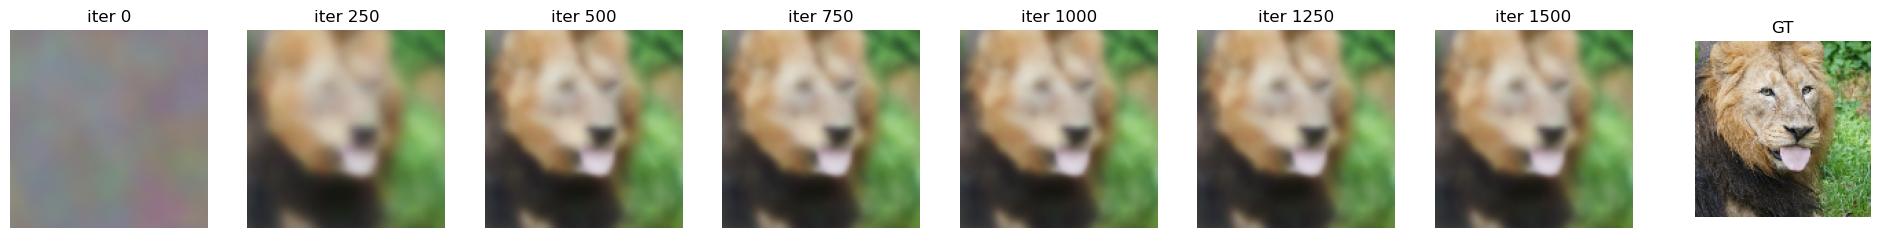

In [245]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict(128)
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_1.0')
# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
net, train_psnr, test_psnr, train_loss, test_loss, predicted_images = \
    NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, stepsize=500, gamma=0.1, opt="Adam", b1=0.9, b2=0.999, eps=1e-8)
# # plot results of experiment
plot_training_curves(train_loss, test_loss, train_psnr, test_psnr)
size /= 2
plot_reconstruction(net.forward(X_train), y_train)
size *= 2
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [268]:
def train_wrapper(mapping, size, opt):
  # TODO implement
  # makes it easy to run all your mapping experiments in a for loop
  # this will similar to what you did previously in the last two sections

  # TODO implement this by using the get_B_dict() and get_input_features() helper functions
  B_dict = get_B_dict(size)
  X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)
    # run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
  net, train_psnr, test_psnr, train_loss, test_loss, predicted_images = \
      NN_experiment(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, stepsize=500, gamma=0.1, opt=opt, b1=0.9, b2=0.999, eps=1e-8)
  return {
      'net': net, 
      'train_psnrs': train_psnr, 
      'test_psnrs': test_psnr,
      'train_loss': train_loss,
      'train_loss': test_loss,
      'pred_imgs': predicted_images
  }

In [275]:
# TODO: Set the hyperparameters for Adam
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 2000
learning_rate = 3 * 1e-5

In [276]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k, "optimizer", opt)
  outputs[k] = train_wrapper(k, mapping_size, opt="Adam")

  0%|          | 0/3 [00:00<?, ?it/s]

training none optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training basic optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training gauss_1.0 optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

In [278]:
# TODO: Set the hyperparameters
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 1000
mapping_size = 32
learning_rate = 1e-1

In [279]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, mapping_size, opt="SGD")

  0%|          | 0/3 [00:00<?, ?it/s]

training none
1000 500 0.1 0.1 SGD {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic
1000 500 0.1 0.1 SGD {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1.0
1000 500 0.1 0.1 SGD {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/1000 [00:00<?, ?it/s]

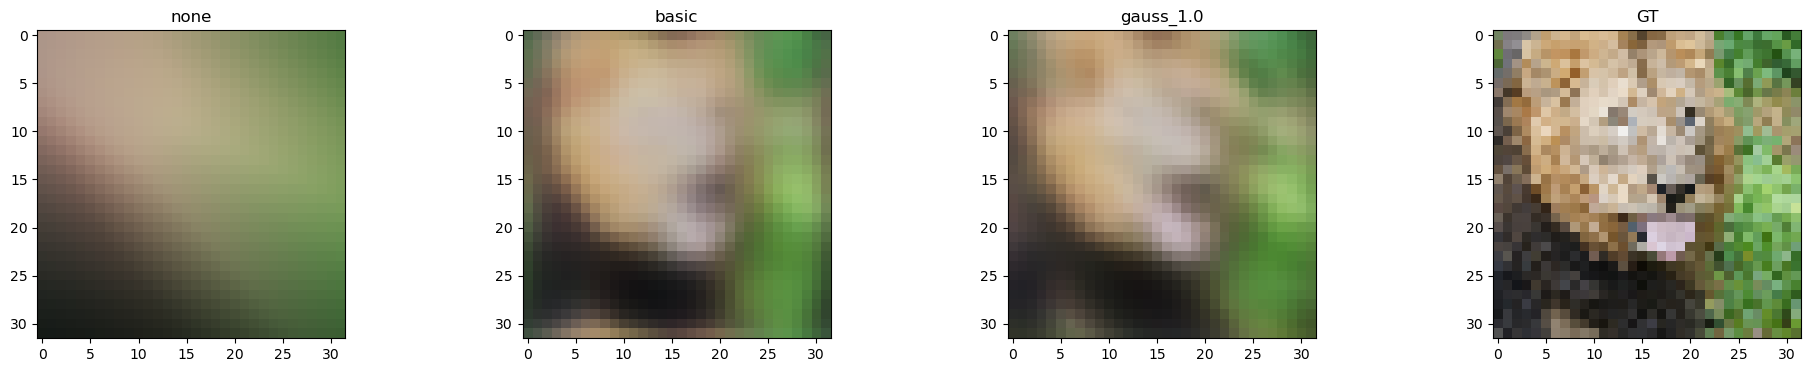

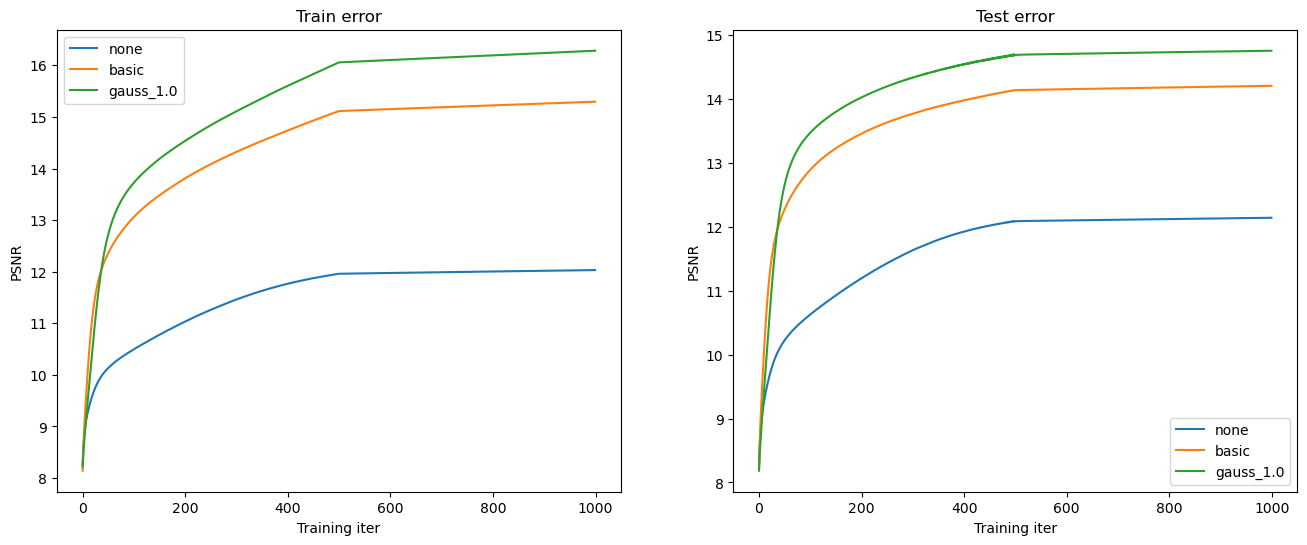

In [281]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

## Extra credits

Considering the limit of time, I just applied the adjustment on the low resolution images because it takes too much time to train and tuning the parametrs for all of the them. The applited extra credits include

* Deep network and the result 
* hyperparameters of Gaussian Fourier 
* loss function()
* regularization 
* Batch normalization
* Pytorch implementation
* image inpainting and restoration


### Hyperparameters of Gaussian Fourier

In [284]:
# TODO: Set the hyperparameters for Adam
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 2000
learning_rate = 3 * 1e-5
B_dict = get_B_dict(mapping_size)

In [285]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k, "optimizer", opt)
  outputs[k] = train_wrapper(k, mapping_size, opt="Adam")

  0%|          | 0/6 [00:00<?, ?it/s]

training none optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training basic optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training gauss_1.0 optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training gauss_0.1 optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training gauss_10 optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

training gauss_100 optimizer Adam
2000 500 0.1 3.0000000000000004e-05 Adam {'b1': 0.9, 'b2': 0.999, 'eps': 1e-08}


  0%|          | 0/2000 [00:00<?, ?it/s]

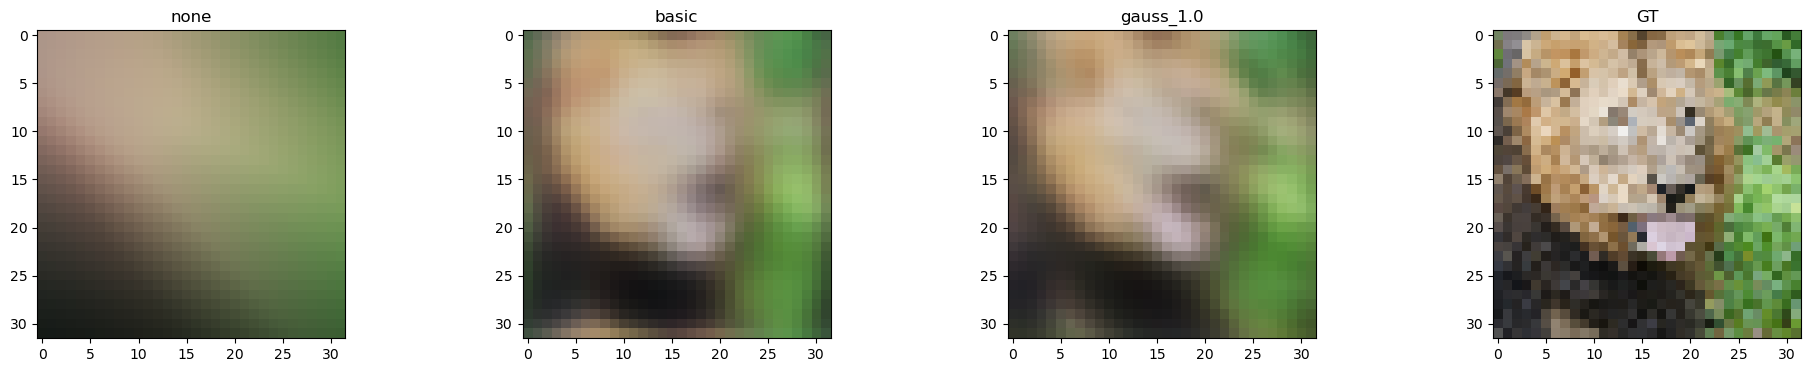

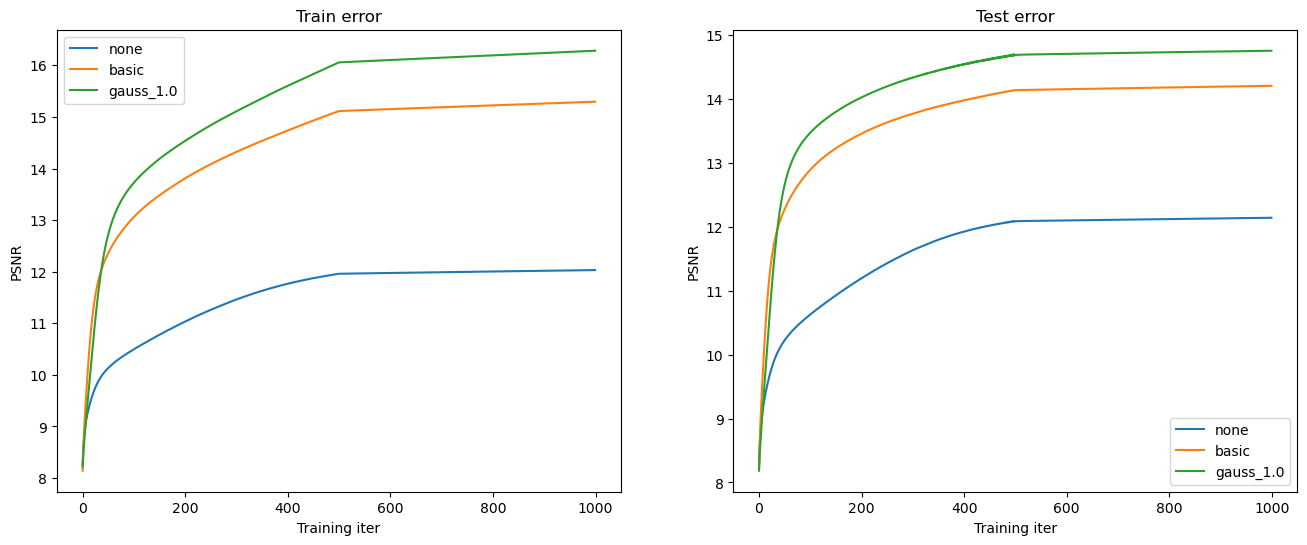

In [ ]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

### Techniques

#### Preprocessing

Preprocessing is one way to process the dataset to make the data distribute more intensely and decrease the impact of outliers. The common way to do the preprocessing is to use $\frac{x - \mu}{\sigma^2}$

In [287]:
def normalize(img):
  avg = np.mean(img)
  std = np.std(img)
  return (img - avg) / std

In [289]:
normalized = []
for i in train_data:
    normalized_img = normalize(i) 
    regularized.append(normalized_img)
train_data = normalized

KeyboardInterrupt: 

#### normalization

As we have mentioned in the lecture, the normalization is always used in small_batch training and always be done after each layers to prevent gradient disappearing. 

The formula to do the normalization is 

The main problems related to achieve batch 

normalization in our model is to do the back propagation of the normalization. As the calculation graph of the model is changed after adding the normalization, we need to add the gradient of batch normalization in our model.



### Pytorch implementation

To use `PyTorch` to implement the model, what we need to change are mainly related to two aspects.

* The model itself: The model now use the default layers defined by PyTorch, like `nn.Linear` and `nn.ReLu`. I use `nn.Sequential` to store all of the hidden layers in network.
* The process of training and testing: as `PyTorch` has defiined how to do the back propagation and has its own way to call the loss function and calculate the  gradients based on it, how to upgrade the value of the parameters will reloaded by `PyTorch` defaulty. 

For other elements, like the train data and test data are all keep the same. Also, for the hyperparameters, to have fair comparission between our model and PyTorch implemented model, I still use the same set of them. 

In [143]:
import torch
from torch import nn
import torch.optim as optim
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.input_layers = nn.Linear(input_size, hidden_size[0])
    hidden_layers = []
    for i in range(len(hidden_size) - 1):
      hidden_layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
      hidden_layers.append(nn.ReLU())
    self.hidden_layers = nn.Sequential(*hidden_layers)
    self.output_layers = nn.Linear(hidden_size[-1], output_size)
    self.sigmoid = nn.Sigmoid()
    
    for m in self.modules():
      if isinstance(m, (nn.BatchNorm2d)):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)
      elif isinstance(m, nn.Linear):
          nn.init.xavier_normal_(m.weight)
          if m.bias is not None:
              nn.init.constant_(m.bias, 0.0)
  def forward(self, x):
    input = self.input_layers(x)
    hidden = self.hidden_layers(input)
    output = self.output_layers(hidden)
    return self.sigmoid(output)
    # return output

In [174]:
# 
# * train of pytorch model
def NN_experiment_torch(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):

    # Initialize a new neural network model
    model = MLP(input_size, hidden_size, output_size)
    if opt == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)
    criterion = nn.MSELoss()
    # criterion = nn.CrossEntropyLoss()
    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    # For each epoch...
    for epoch in tqdm(range(epochs)):

      # Shuffle the dataset
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffle = X_train[indices]
        y_train_shuffle = y_train[indices]
        X_train_shuffle = torch.tensor(X_train_shuffle, dtype=torch.float32)
        y_train_shuffle = torch.tensor(y_train_shuffle, dtype=torch.float32)
        # TODO implement this
        model.train()
        output = model.forward(X_train_shuffle)
        loss = criterion(output, y_train_shuffle)
    #   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        # Testing
        # No need to run the backward pass here, just run the forward pass to compute and record the psnr
        # validate_image = net.forward(X_train)
        model.eval()
        y_pred = model.forward(X_train_tensor)
        train_psnr[epoch] = psnr(y_train, y_pred.detach().numpy())
        predicted_images[epoch] = model.forward(X_test_tensor).detach().numpy()
        # TODO implement this
        train_loss[epoch] = criterion(y_train_tensor, torch.tensor(y_pred)).detach().numpy()
        test_loss[epoch] = criterion(y_test_tensor, torch.tensor(predicted_images[epoch])).detach().numpy()
        test_psnr[epoch] = psnr(y_test, predicted_images[epoch])

    return model, train_psnr, test_psnr, train_loss, test_loss, predicted_images

In [185]:
#TODO: set the hyperparameters
#! SGD
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 1000
learning_rate = 5 * 1e-1

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\2531341224.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss[epoch] = criterion(y_train_tensor, torch.tensor(y_pred)).detach().numpy()


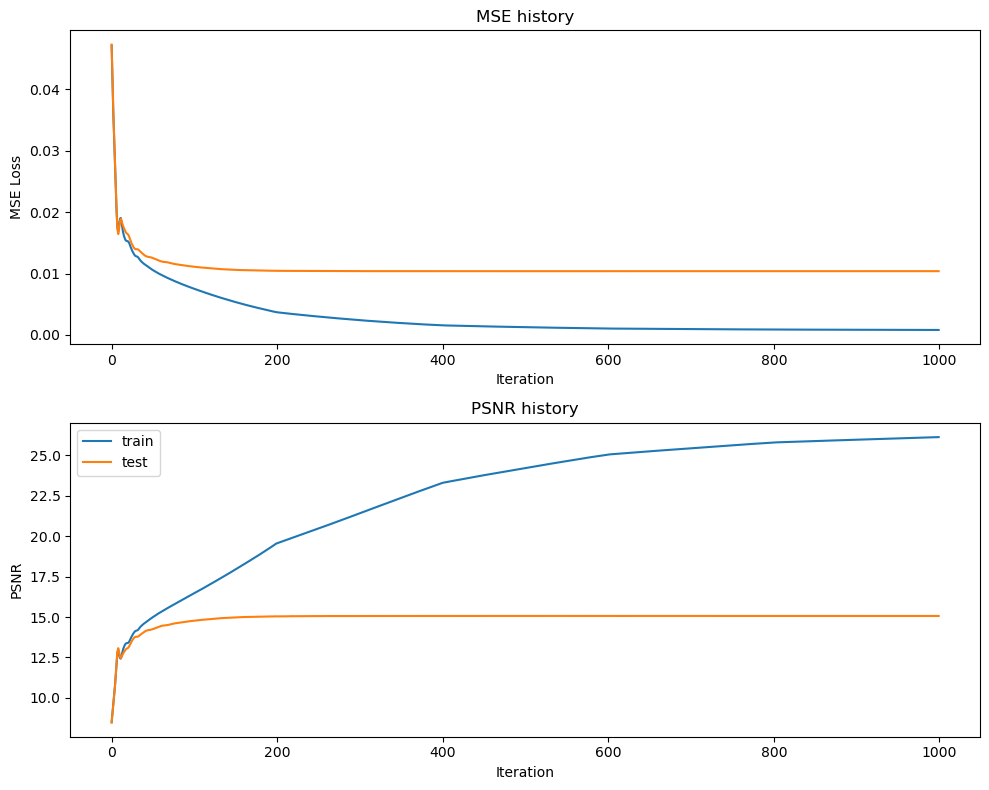

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\3713347882.py:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


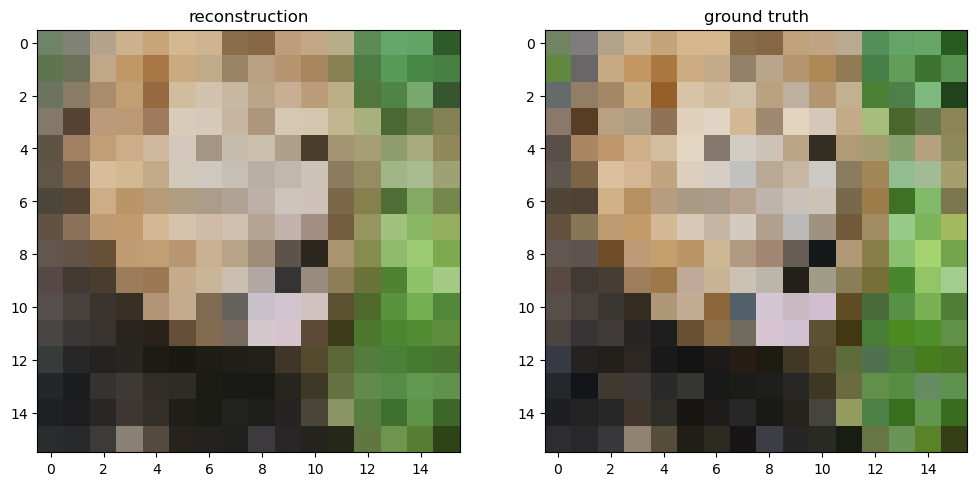

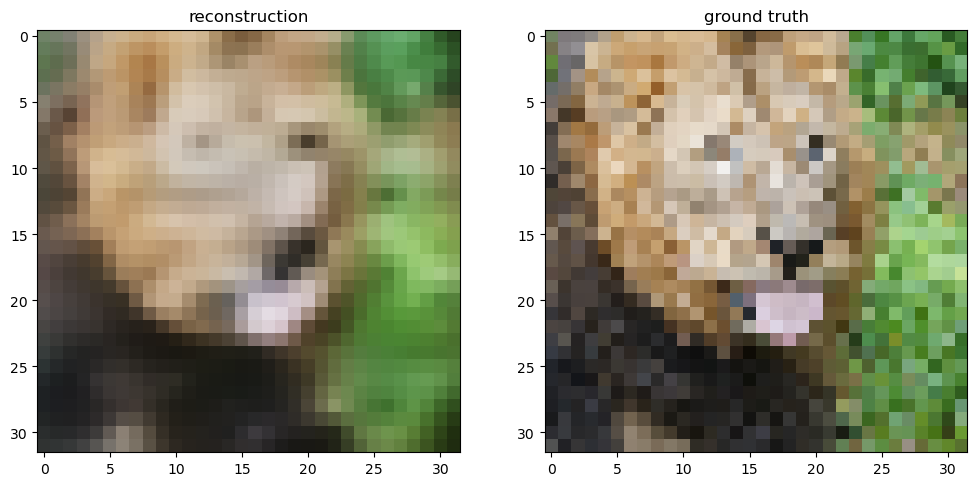

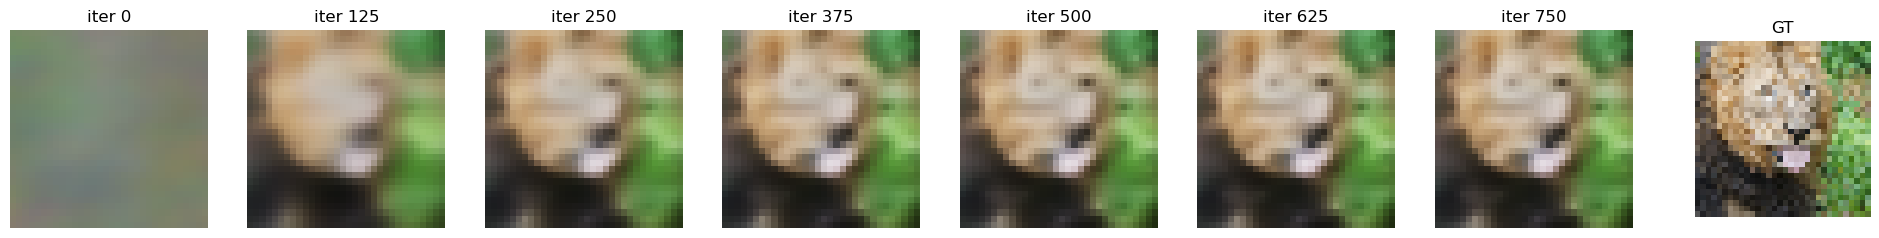

In [186]:
# get input features
# ! SGD
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_1.0')
# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
net, train_psnr, test_psnr, train_loss, test_loss, predicted_images = \
    NN_experiment_torch(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt="SGD")
# plot results of experiment
plot_training_curves(train_loss, test_loss, train_psnr, test_psnr)
size = 16
plot_reconstruction(net.forward(torch.tensor(X_train, dtype=torch.float32)).detach().numpy(), y_train)
size = 32
plot_reconstruction(net.forward(torch.tensor(X_test, dtype=torch.float32)).detach().numpy(), y_test)
plot_reconstruction_progress(predicted_images, y_test)

In [234]:
# TODO: Set the hyperparameters
# ! Adam
num_layers = 5
hidden_size = [256, 512, 512, 256]
hidden_sizes = [hidden_size] * (num_layers - 1)
epochs = 1000
learning_rate = 3 * 1e-5
mapping_size = 16
output_size = 3
B_dict = get_B_dict(mapping_size)

print('B_dict items:')
for k,v in B_dict.items():
    print('\t',k,np.array(v).shape)

B_dict items:
	 none ()
	 basic (2, 2)
	 gauss_1.0 (8, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\2531341224.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss[epoch] = criterion(y_train_tensor, torch.tensor(y_pred)).detach().numpy()


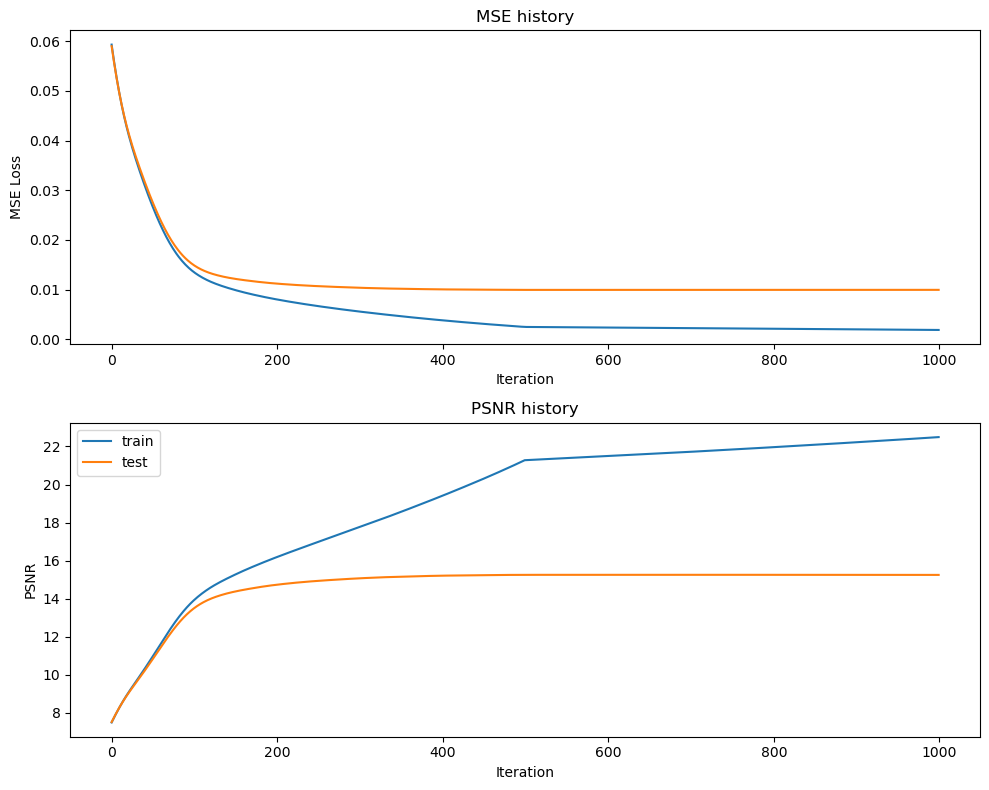

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\3713347882.py:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


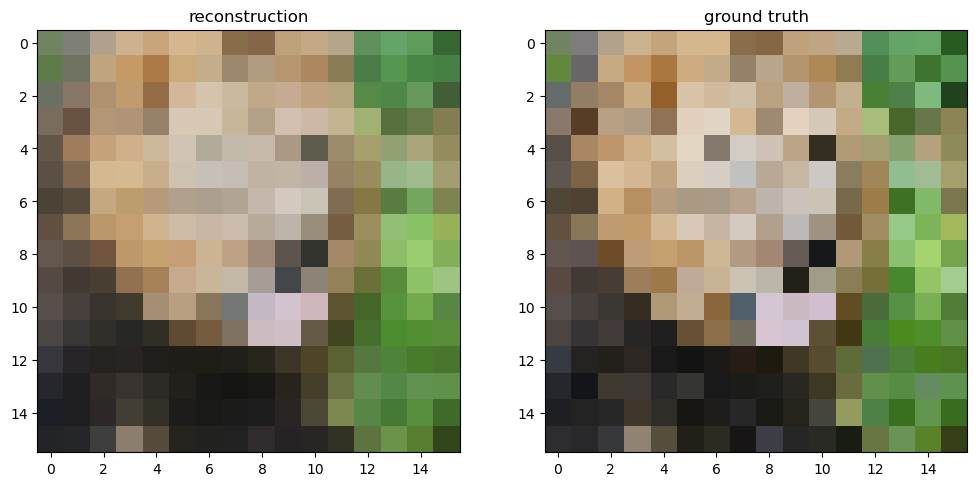

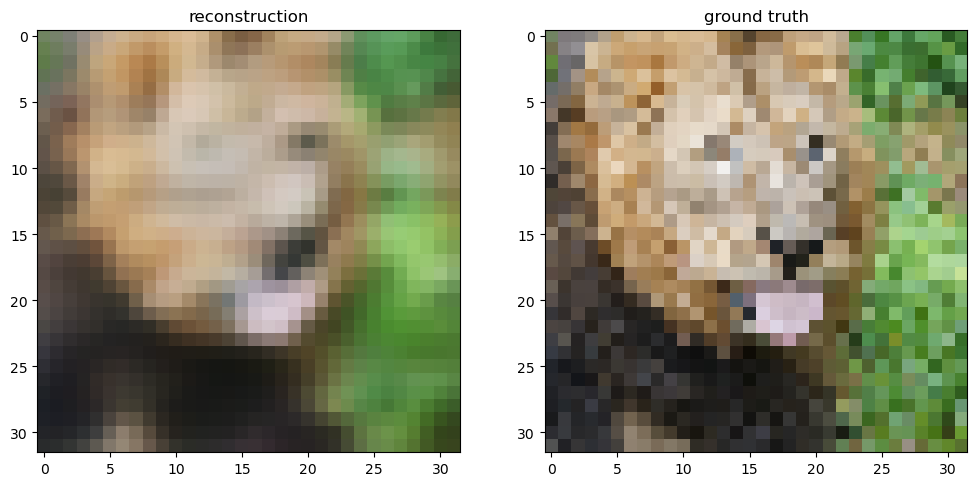

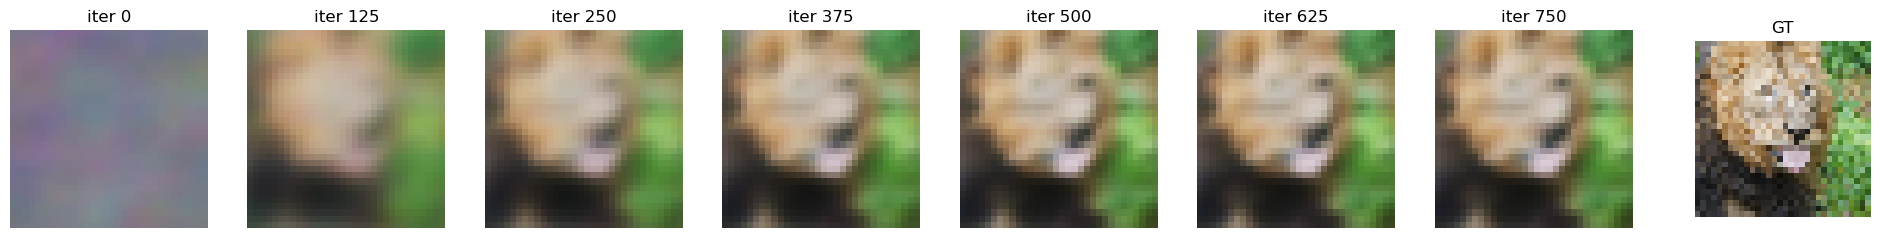

In [235]:
# get input features
# ! Adam
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_1.0')
# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
net, train_psnr, test_psnr, train_loss, test_loss, predicted_images = \
    NN_experiment_torch(X_train, y_train, X_test, y_test, X_train.shape[1], num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt="Adam")
# plot results of experiment
plot_training_curves(train_loss, test_loss, train_psnr, test_psnr)
size = 16
plot_reconstruction(net.forward(torch.tensor(X_train, dtype=torch.float32)).detach().numpy(), y_train)
size = 32
plot_reconstruction(net.forward(torch.tensor(X_test, dtype=torch.float32)).detach().numpy(), y_test)
plot_reconstruction_progress(predicted_images, y_test)

### Image inpainting and restoration

Our trained model is generate the original image from random pixel and it is a typical depth-prediction task. To use our model on the similiar depth-prediction task, we will keep the same structure of the model and only change the data for them.

#### Inpaint 

Inpaint is to train model to generate pixel to fill a masked region of an image. For the inpaint task, we want the model to learn as much as the pixel distribution of the image so that it can fill any region taken from the image. 

As a result, we will use the same image for both the training and testing. However, to better test our model's preformance
* For the training data, we will use the image that is randomly masked. The mask will change each epoch instead of shuffleing the data
* For the testing data, we will use the fixed mask. 

In [ ]:
def get_inpaint_img(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center  
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

#### Resoration

In [ ]:
def get_restoration_img(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center  
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution. The reason why we have you first experiment with the lower resolution since it is faster to train and debug. Additionally, you will see how the mapping strategies perform better or worse at the two different input resolutions. 

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


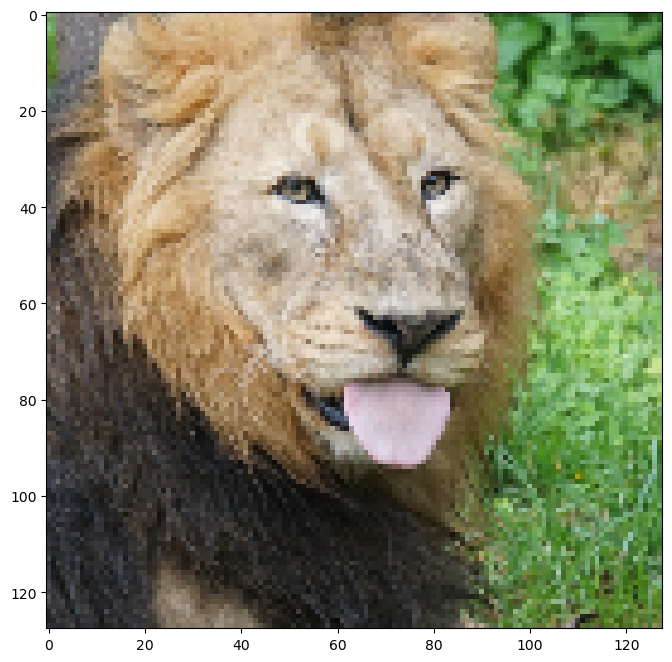

In [236]:
size = 128
train_data, test_data = get_image(size)

In [237]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size,)

  0%|          | 0/3 [00:00<?, ?it/s]

training none


NameError: name 'train_wrapper' is not defined

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template. 

C:\Users\73721\AppData\Local\Temp\ipykernel_2068\2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


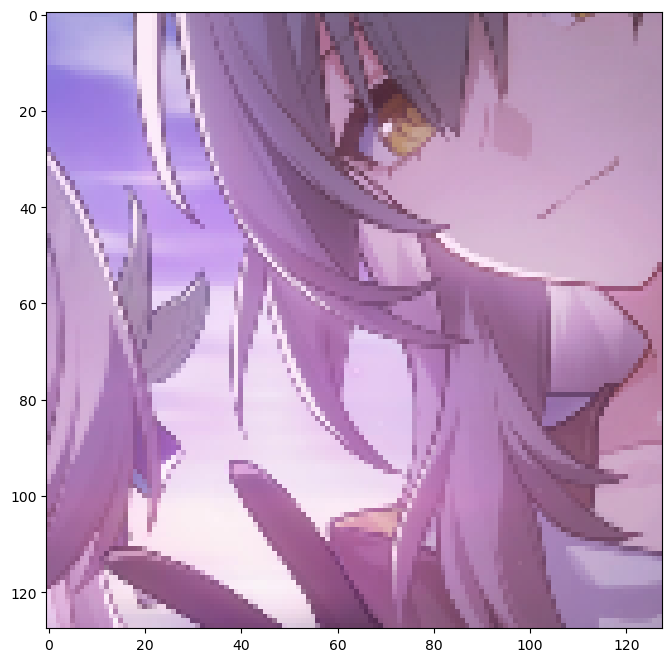

In [250]:
size = 128
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="https://s11.ax1x.com/2024/03/05/pFDYuQJ.png")


In [ ]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [ ]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

In [ ]:
# single video example
create_and_visualize_video({"gauss": {"pred_imgs": predicted_images}}, filename="training_high_res_gauss.mp4")

In [ ]:
# multi video example
create_and_visualize_video(outputs, epochs=1000, size=32)